# CBP Data Processing

## Summary
Notebook to extract the contents of CBP pdf on apprehensions by nationality at specfiic border crossings. 

Mostly automated but some manual work.

Additional notes:
* Totals may not match 100% - appears from comparing TOTAL column and summed totals to be off - generally low rate but would want to add more verification and testing if we plan on using or sharing this data more broadly. 
* There are many other pdfs which could be extracted - holding for now until we determine if there is value in extracting them 

dataset source: https://www.cbp.gov/newsroom/media-resources/stats <br>
specific file link: https://www.cbp.gov/sites/default/files/assets/documents/2021-Aug/USBORD~3.PDF

In [8]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


**Change the directory to your local copy of the data repo**

In [9]:
%cd /content/drive/MyDrive/data-repo-mvps

/content/drive/Shareddrives/Data Products Team/Products/Immigration Data Hub/DataRepo/data-repo-mvp


In [1]:
!pip install PyPDF2
!pip install tabula-py

In [2]:
import pandas as pd
import requests
import tabula


from pathlib import Path
from PyPDF2 import PdfFileReader
pd.set_option("max_rows", 400)

In [5]:
def download_pdf(url, name, output_folder):
    """
    Function to download a single pdf file from a provided link.

    Parameters:
      url: Url of the file you want to download
      name: name label you want to apply to the file
      output_folder: Folder path to savae file

    Returns:
      Saves the file to the output directory, function itself returns nothing.

    Example:
      download_pdf(
        'https://travel.state.gov/content/travel/en/legal/visa-law0/visa-statistics/immigrant-visa-statistics/monthly-immigrant-visa-issuances.html',
        'July 2020 - IV Issuances by Post and Visa Class',
        'visa_test/'
      )
    """
    output_folder = Path(output_folder)
    response = requests.get(url)
    if response.status_code == 200:
        # Write content in pdf file
        outpath = output_folder / f"{name}.pdf"
        pdf = open(str(outpath), "wb")
        pdf.write(response.content)
        pdf.close()
        print("File ", f"{name}.pdf", " downloaded")
    else:
        print("File ", f"{name}.pdf", " not found.")


In [6]:
name = "US Border Patrol Nationwide Apps by Citizenship & Sector"

In [14]:
download_pdf(
    'https://www.cbp.gov/sites/default/files/assets/documents/2021-Aug/USBORD~3.PDF',
    name, 
    '../data-repo-mvp/data/raw_source_files/'
)

File  US Border Patrol Nationwide Apps by Citizenship & Sector.pdf  downloaded


In [7]:
path = "../data-repo-mvp/data/raw_source_files/US Border Patrol Nationwide Apps by Citizenship & Sector.pdf"
print(path)
pdf = PdfFileReader(path)

../data-repo-mvp/data/raw_source_files/US Border Patrol Nationwide Apps by Citizenship & Sector.pdf


We manually define the columns based on the table structure - see link to pdf above or visit local pdf to verify. 

TODO - perhaps insert picture of table here to make this more clear 

In [8]:
cols = [
    "citizenship",
    "bbt",
    "drt",
    "elc",
    "ept",
    "lrt",
    "rgv",
    "sdc",
    "tca",
    "yum",
    "sbo_total",  # SBO
    "blw",
    "bun",
    "dtm",
    "gfn",
    "hlt",
    "hvm",
    "spw",
    "swb",
    "nbo_total",
    "mip",
    "nll",
    "rmy",
    "cbo_total",
    "total",
]

In [9]:
def fix_header_pages(df):
    df.columns = cols
    df = df.drop([0, 1], axis=0)
    return df

In [10]:
tables = []
table_segments = pd.DataFrame()
start = 1
stop = pdf.getNumPages()+1
table_num = -1
for i in range(start, stop):
    new_table = False
    df = tabula.read_pdf(
        path, pages=f"{i}", lattice=True, pandas_options={"header": None}
    )[0]

    if "AFGHANISTAN" in df.loc[2][0]:
        new_table = True
        table_num += 1

    if "CITIZENSHIP" in df.loc[0][0]:
        df = fix_header_pages(df)  # Mixed formats in this pdf
    else:
        df.columns = cols

    check_for_error = df[df.citizenship.str.isdigit()]
    if len(check_for_error) > 0:
        fixed = False
        missing_country_df = tabula.read_pdf(
            path,
            pages=f"{i}",
            stream=True,
            area=(500, 5.65, 570, 5.65 + 800),
            pandas_options={"header": None},
        )[0]
        missing_country = missing_country_df.tail(1)[0].squeeze()
        print(f"ERROR!! pg:{i}, country={missing_country}, table_num={table_num}")

        if missing_country_df.shape[1] == df.shape[1]:
            fixed = True
            print("Success - Likely Fixed Automatically")
            missing_country_df.columns = cols
            df.loc[check_for_error.index[0]] = missing_country_df.iloc[-1]
        if not fixed:
            df.loc[
                check_for_error.index[0], "citizenship"
            ] = f"ERROR - {missing_country}"

    # Check if new table
    if i != start and new_table:
        tables.append(table_segments)
        table_segments = df

    else:
        table_segments = table_segments.append(df)
tables.append(table_segments)

ERROR!! pg:35, country=SYRIA, table_num=11
ERROR!! pg:37, country=IRELAND, table_num=12
Success - Likely Fixed Automatically
ERROR!! pg:38, country=UNKNOWN, table_num=12


## Manual Fixes
These rows were not captured correctly because the last row didn't have a full line. Using the STREAM option in Tabula I'm able to grab the name of the "citizenship" but the data was not parsed correctly. 

In [11]:
syria_correct = [
    "SYRIA",
    0,
    0,
    0,
    1,
    2,
    0,
    0,
    0,
    0,
    3,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    3,
]
len(syria_correct)

25

In [12]:
unknown_correct = [
    "UNNKOWN",
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
]
len(unknown_correct)

25

In [13]:
tbl_index = 11
tables[tbl_index].loc[
    tables[tbl_index][tables[tbl_index].citizenship.str.contains("SYRIA")].index[0]
] = syria_correct

In [14]:
tbl_index = 12
tables[tbl_index].loc[
    tables[tbl_index][tables[tbl_index].citizenship.str.contains("UNKNOWN")].index[0]
] = unknown_correct

## Clean Up Tables

In [22]:
station_cols = [
    i
    for i in cols
    if i not in ["citizenship", "sbo_total", "nbo_total", "cbo_total", "total"]
]

total_cols = [ "sbo_total", "nbo_total", "cbo_total", "total"]
def clean_tables(df):
    df = df.fillna(0).reset_index(drop=True)
    df["total"] = [
        int(i.replace(",", "")) if isinstance(i, str) else i for i in df["total"]
    ]
    for c in station_cols + total_cols:
        df.loc[:, c] = [
            int(i.replace(",", "")) if isinstance(i, str) else i for i in df[c]
        ]

    return df

In [23]:
data = {
    f"total_apprehensions_FY{idx+7:02}": clean_tables(df)
    for idx, df in enumerate(tables)
}

In [24]:
table_name = 'total_apprehensions_FY19'
totals = data[table_name].query('citizenship == "TOTAL"')
pd.concat([data[table_name].query('citizenship != "TOTAL"').sum(axis=0),
           totals.T],axis=1)

,0,148
citizenship,AFGHANISTANALBANIAALGERIAANGOLAANTIGUA-BARBUDA...,TOTAL
bbt,9637,9637
drt,57269,57269
elc,35138,35138
ept,182143,182143
lrt,38378,38378
rgv,339135,339135
sdc,58049,58049
tca,63490,63490
yum,68269,68269


In [25]:
combined = pd.DataFrame()
for k in data:
    tmp = data[k]
    tmp["label"] = k
    combined = combined.append(tmp)

In [26]:
combined["year"] = combined.label.apply(lambda x: int(f"20{x[-2:]}"))

In [27]:
combined

,citizenship,bbt,drt,elc,ept,lrt,rgv,sdc,tca,yum,...,spw,swb,nbo_total,mip,nll,rmy,cbo_total,total,label,year
0,AFGHANISTAN,0,0,0,0,0,0,0,0,1,...,0.0,1.0,1,0,0.0,0.0,0,2,total_apprehensions_FY07,2007
1,ALBANIA,0,0,0,1,3,4,0,0,0,...,0.0,6.0,13,0,0.0,0.0,0,21,total_apprehensions_FY07,2007
2,ALGERIA,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0,1,total_apprehensions_FY07,2007
3,ANGOLA,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0,1,total_apprehensions_FY07,2007
4,ANTIGUA-BARBUDA,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1,2,1.0,0.0,3,4,total_apprehensions_FY07,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,YEMEN,0,8,1,2,1,4,5,0,7,...,0.0,0.0,0,0,0.0,0.0,0,28,total_apprehensions_FY20,2020
138,YUGOSLAVIA,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,0,0.0,0.0,0,1,total_apprehensions_FY20,2020
139,ZAMBIA,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,1,0.0,0.0,1,2,total_apprehensions_FY20,2020
140,ZIMBABWE,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1,0,0.0,0.0,0,2,total_apprehensions_FY20,2020


In [29]:
combined.citizenship = [str(i) for i in combined.citizenship]

In [30]:
combined.to_csv('./data/extracted_data/cbp-apprehensions-nov2021.csv')

# Examine

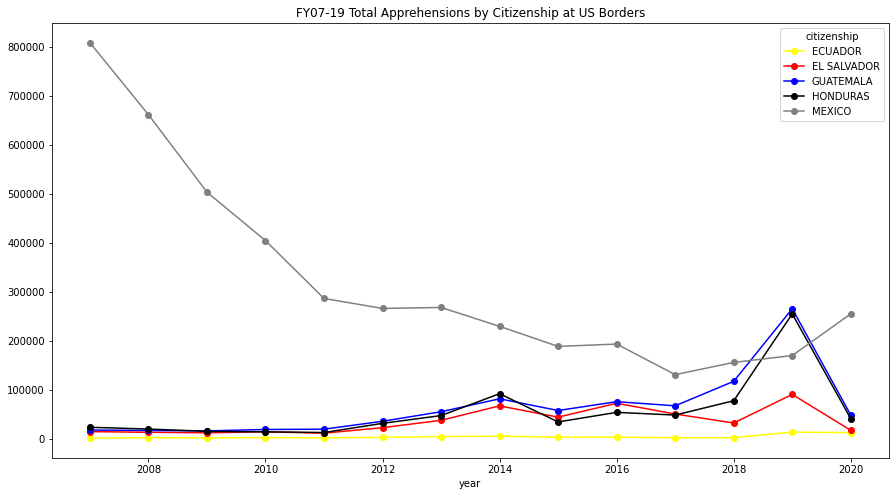

In [40]:
pd.pivot(
    index="year",
    columns="citizenship",
    values="total",
    data=combined[
        combined.citizenship.isin(
            combined.groupby("citizenship")
            .sum()
            .sort_values("total", ascending=False)
            .head(5)
            .index.tolist()
        )
    ],
).plot(
    figsize=(15, 8),
    marker="o",
    color=["yellow", "red", "blue", "black", "gray"],
    title="FY07-19 Total Apprehensions by Citizenship at US Borders",
)